


# <img src="assests/voxel51_logo.png" alt="Image2" width="40"/> FiftyOne + Mosaic AI Vector Search with Databricks<img src="assests/db_logo.png" alt="Image1" width="80"/>
This notebook demonstrates how to build a complete visual search workflow using **FiftyOne** and **Mosaic AI Vector Search on Databricks**.

You will learn how to:
- Set up your Databricks catalog and vector search endpoint
- Load and index embeddings using FiftyOne
- Query by image and text
- Visualize results in the FiftyOne App

🧠 This integration helps you scale visual search over large datasets with a cloud-native vector database.

👉 For more, see the official [FiftyOne + Mosaic AI docs](https://docs.voxel51.com/integrations/mosaic.html)


<img src="assests/mosaic_fiftyone_recipe.png" alt="Image2" width="600"/>

https://github.com/user-attachments/assets/2f5f21b3-5f42-4ab5-8e29-e1cac3e8eeb1

In [ ]:
# Install necessary packages
#!pip install fiftyone databricks-vectorsearch torch torchvision python-dotenv mlflow umap-learn


## 🔐 Set Up Environment Variables
You need access to a Databricks account with **Vector Search enabled**.
Follow these steps:
1. **Create a Catalog**: Go to `Catalog` → `Add Data` → `Create a new Catalog`
2. **Create a Vector Search Endpoint**: Go to `Compute` → `Vector Search` → `Create`
3. **Create a Schema** inside your Catalog (FiftyOne will handle the columns later)

⚠️ You must have a Personal Access Token for authentication.

### 🔧 Option 1: Use a `.env` File
You can store your credentials securely in a `.env` file:
```bash
FIFTYONE_BRAIN_SIMILARITY_MOSAIC_WORKSPACE_URL=https://your.cloud.databricks.com/
FIFTYONE_BRAIN_SIMILARITY_MOSAIC_PERSONAL_ACCESS_TOKEN=your_token
FIFTYONE_BRAIN_SIMILARITY_MOSAIC_CATALOG_NAME=your_catalog
FIFTYONE_BRAIN_SIMILARITY_MOSAIC_SCHEMA_NAME=your_schema
FIFTYONE_BRAIN_SIMILARITY_MOSAIC_ENDPOINT_NAME=your_endpoint
```

In [ ]:
# 🔁 Load .env variables
# from dotenv import load_dotenv
# load_dotenv()

### 🔧 Option 2: Set Environment Variables in Code
This is useful for notebooks or ephemeral environments:
```python
import os
os.environ["FIFTYONE_BRAIN_SIMILARITY_MOSAIC_WORKSPACE_URL"] = "https://your.cloud.databricks.com/"
os.environ["FIFTYONE_BRAIN_SIMILARITY_MOSAIC_PERSONAL_ACCESS_TOKEN"] = "your_token"
os.environ["FIFTYONE_BRAIN_SIMILARITY_MOSAIC_CATALOG_NAME"] = "your_catalog"
os.environ["FIFTYONE_BRAIN_SIMILARITY_MOSAIC_SCHEMA_NAME"] = "your_schema"
os.environ["FIFTYONE_BRAIN_SIMILARITY_MOSAIC_ENDPOINT_NAME"] = "your_endpoint"
os.environ["DATABRICKS_HOST"] = os.environ["FIFTYONE_BRAIN_SIMILARITY_MOSAIC_WORKSPACE_URL"]
os.environ["DATABRICKS_TOKEN"] = os.environ["FIFTYONE_BRAIN_SIMILARITY_MOSAIC_PERSONAL_ACCESS_TOKEN"]
```

In [ ]:
# import os
# os.environ["FIFTYONE_BRAIN_SIMILARITY_MOSAIC_WORKSPACE_URL"] = "https://your.cloud.databricks.com/"
# os.environ["FIFTYONE_BRAIN_SIMILARITY_MOSAIC_PERSONAL_ACCESS_TOKEN"] = "your_token"
# os.environ["FIFTYONE_BRAIN_SIMILARITY_MOSAIC_CATALOG_NAME"] = "your_catalog"
# os.environ["FIFTYONE_BRAIN_SIMILARITY_MOSAIC_SCHEMA_NAME"] = "your_schema"
# os.environ["FIFTYONE_BRAIN_SIMILARITY_MOSAIC_ENDPOINT_NAME"] = "your_endpoint"

# These are critical for the SDK/MLflow auth
# os.environ["DATABRICKS_HOST"] = os.environ["FIFTYONE_BRAIN_SIMILARITY_MOSAIC_WORKSPACE_URL"]
# os.environ["DATABRICKS_TOKEN"] = os.environ["FIFTYONE_BRAIN_SIMILARITY_MOSAIC_PERSONAL_ACCESS_TOKEN"]

## 👌 Validate Authentication to Databricks
Make sure your token works by initializing a Databricks SDK client and confirming your identity.

In [ ]:
#Run this to checl everything is in place:
from databricks.sdk import WorkspaceClient

client = WorkspaceClient()
me = client.current_user.me()
print("Authenticated as:", me.user_name)

### 🏁 Create an endpoint in your catalog.

Be sure you have the following setup. Catalog -> Vector Search -> Endpoint. The FiftyOne integration will manage the rest. No worries about adding variables to your schema or settng up a vector search index, FiftyOne will manage it by you. 

In [ ]:
from databricks.vector_search.client import VectorSearchClient


# The following line automatically generates a PAT Token for authentication
client = VectorSearchClient()

# The following line uses the service principal token for authentication
# client = VectorSearchClient(service_principal_client_id=<CLIENT_ID>,service_principal_client_secret=<CLIENT_SECRET>)

client.create_endpoint(
    name="vector_search_fiftyone_cluster",
    endpoint_type="STANDARD"
)

Wait until this endpoint is ready, any action before that can create a 500 or 400 HTTP Error.

## 📁 Load the Quickstart Dataset and Launch FiftyOne
We will use the `quickstart` dataset from FiftyOne's built-in zoo to demonstrate embedding and vector indexing.

Dataset already downloaded
Loading existing dataset 'quickstart'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use



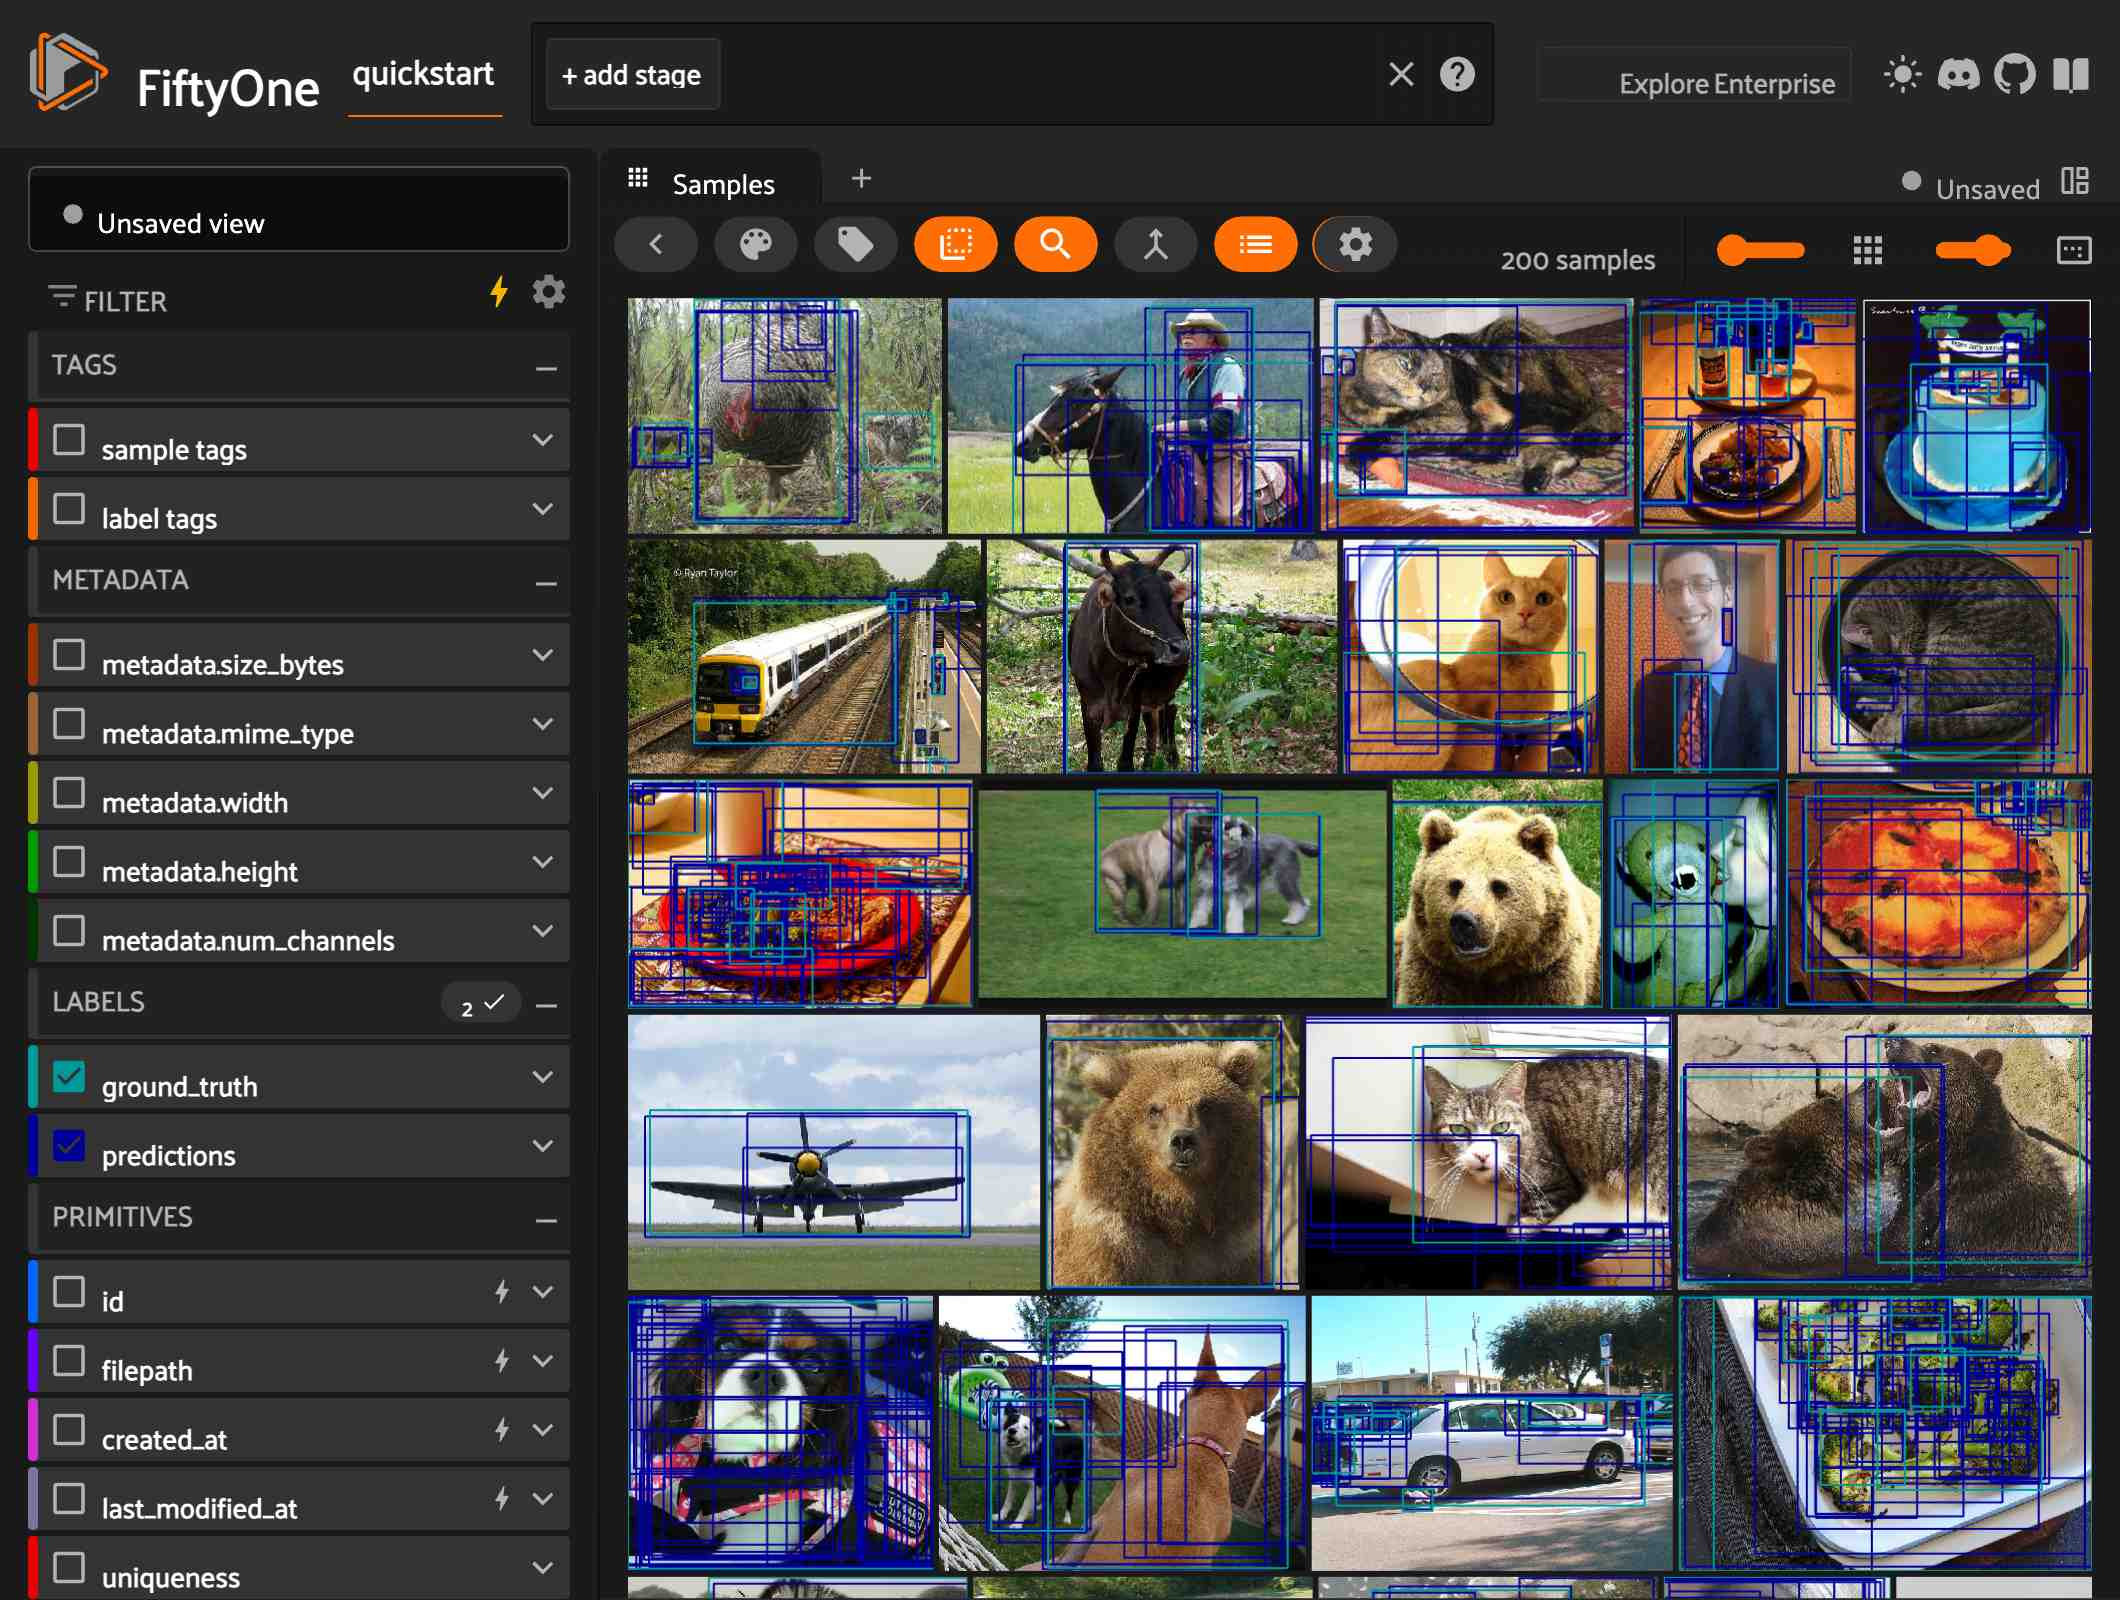

In [3]:
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob

dataset = foz.load_zoo_dataset("quickstart")
session = fo.launch_app(dataset)

![Image](assests/fiftyone_APP.png)

## Using the Mosaic backend
By default, calling ```compute_similarity()``` or ```sort_by_similarity()``` will use an sklearn backend.
To use the Mosaic backend, simply set the optional backend parameter of ```compute_similarity()``` to ```mosaic```:

## 🧠 Compute Embeddings and Index with Mosaic AI
Now we compute a similarity index using the Mosaic backend. This will:
- Use a CLIP model to generate embeddings
- Push them to your Databricks endpoint
- Store them as a Direct Access Index

In [5]:
mosaic_index = fob.compute_similarity(
    dataset,
    model="clip-vit-base32-torch",
    backend="mosaic",
    brain_key="mosaic_index_5",
    index_name="fiftyone_index",
)

[NOTICE] Using a Personal Authentication Token (PAT). Recommended for development only. For improved performance, please use Service Principal based authentication. To disable this message, pass disable_notice=True.
Computing embeddings...
 100% |█████████████████| 200/200 [4.9s elapsed, 0s remaining, 42.2 samples/s]      


When you run ```compute_similarity()``` FiftyOne calcules embeddings on the fly, and you can see the vector values in the Databricks Schema that we previously setup.

![Image](assests/databricks_view.png)

https://github.com/user-attachments/assets/89ad39c8-baef-420b-a3a2-ccb074046b51

In [6]:
# Retrieve embeddings for a view
ids = dataset.take(10).values("id")
embeddings, sample_ids, _ = mosaic_index.get_embeddings(sample_ids=ids)
print(embeddings.shape)  # (10, 512)
print(sample_ids.shape)  # (10,)

(10, 512)
(10,)


In [7]:
# Get all embeddings from the MosaicSimilarityIndex
embeddings, sample_ids, _ = mosaic_index.get_embeddings()

# Confirm shape
print("Embeddings shape:", embeddings.shape)  # (N, D) => N samples, D dimensions
print("Sample IDs shape:", sample_ids.shape)

Embeddings shape: (200, 512)
Sample IDs shape: (200,)


### 📦 Install `umap-learn`
`umap-learn` is required to visualize high-dimensional embeddings in 2D or 3D.

```bash
pip install umap-learn
```

Generating visualization...


/Users/paularamos/Documents/DB_demo/fiftyone_DB_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/paularamos/Documents/DB_demo/fiftyone_DB_env/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP( verbose=True)
Mon Apr 14 20:51:21 2025 Construct fuzzy simplicial set
Mon Apr 14 20:51:21 2025 Finding Nearest Neighbors
Mon Apr 14 20:51:22 2025 Finished Nearest Neighbor Search
Mon Apr 14 20:51:23 2025 Construct embedding


Epochs completed: 100%| ██████████ 500/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Apr 14 20:51:24 2025 Finished embedding



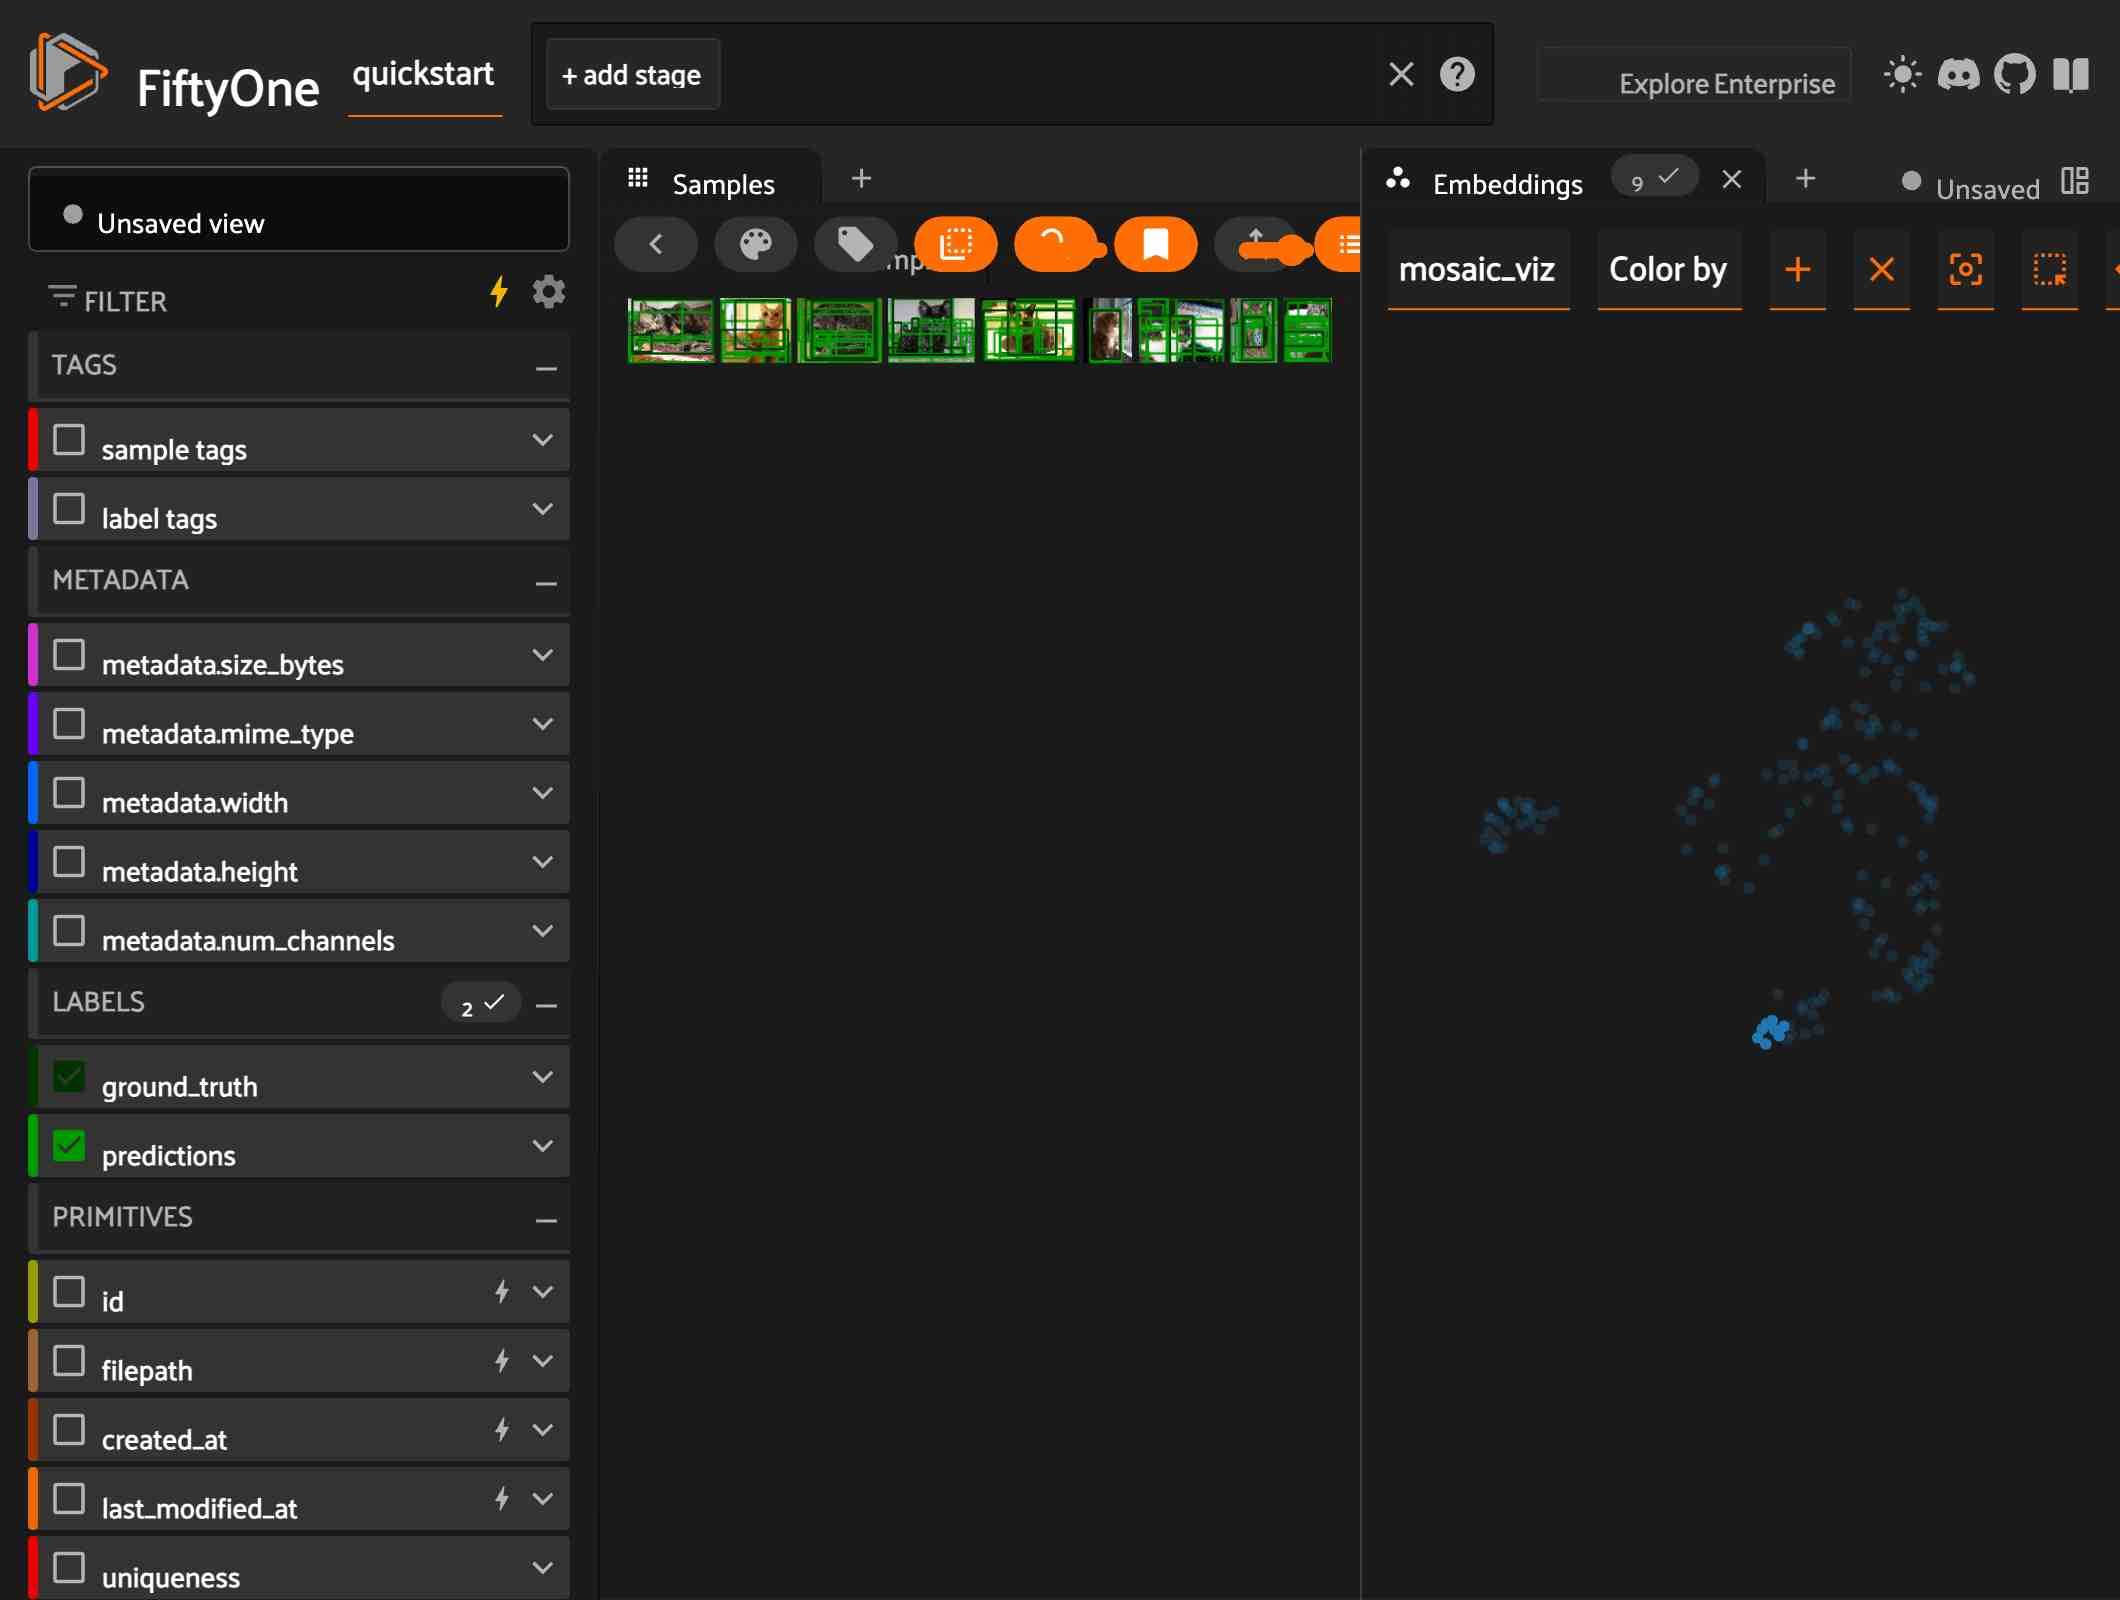

In [ ]:
# Compute the visualization
fob.compute_visualization(
    dataset,                      # your FiftyOne dataset
    embeddings=embeddings,        # the N x D matrix
    brain_key="mosaic_viz",       # identifier for visualization (name it!)
    sample_ids=sample_ids         # make sure this matches the dataset
)
session = fo.launch_app(dataset)


![Image](assests/emb.png)

## Query the Similarity Index

[NOTICE] Using a Personal Authentication Token (PAT). Recommended for development only. For improved performance, please use Service Principal based authentication. To disable this message, pass disable_notice=True.



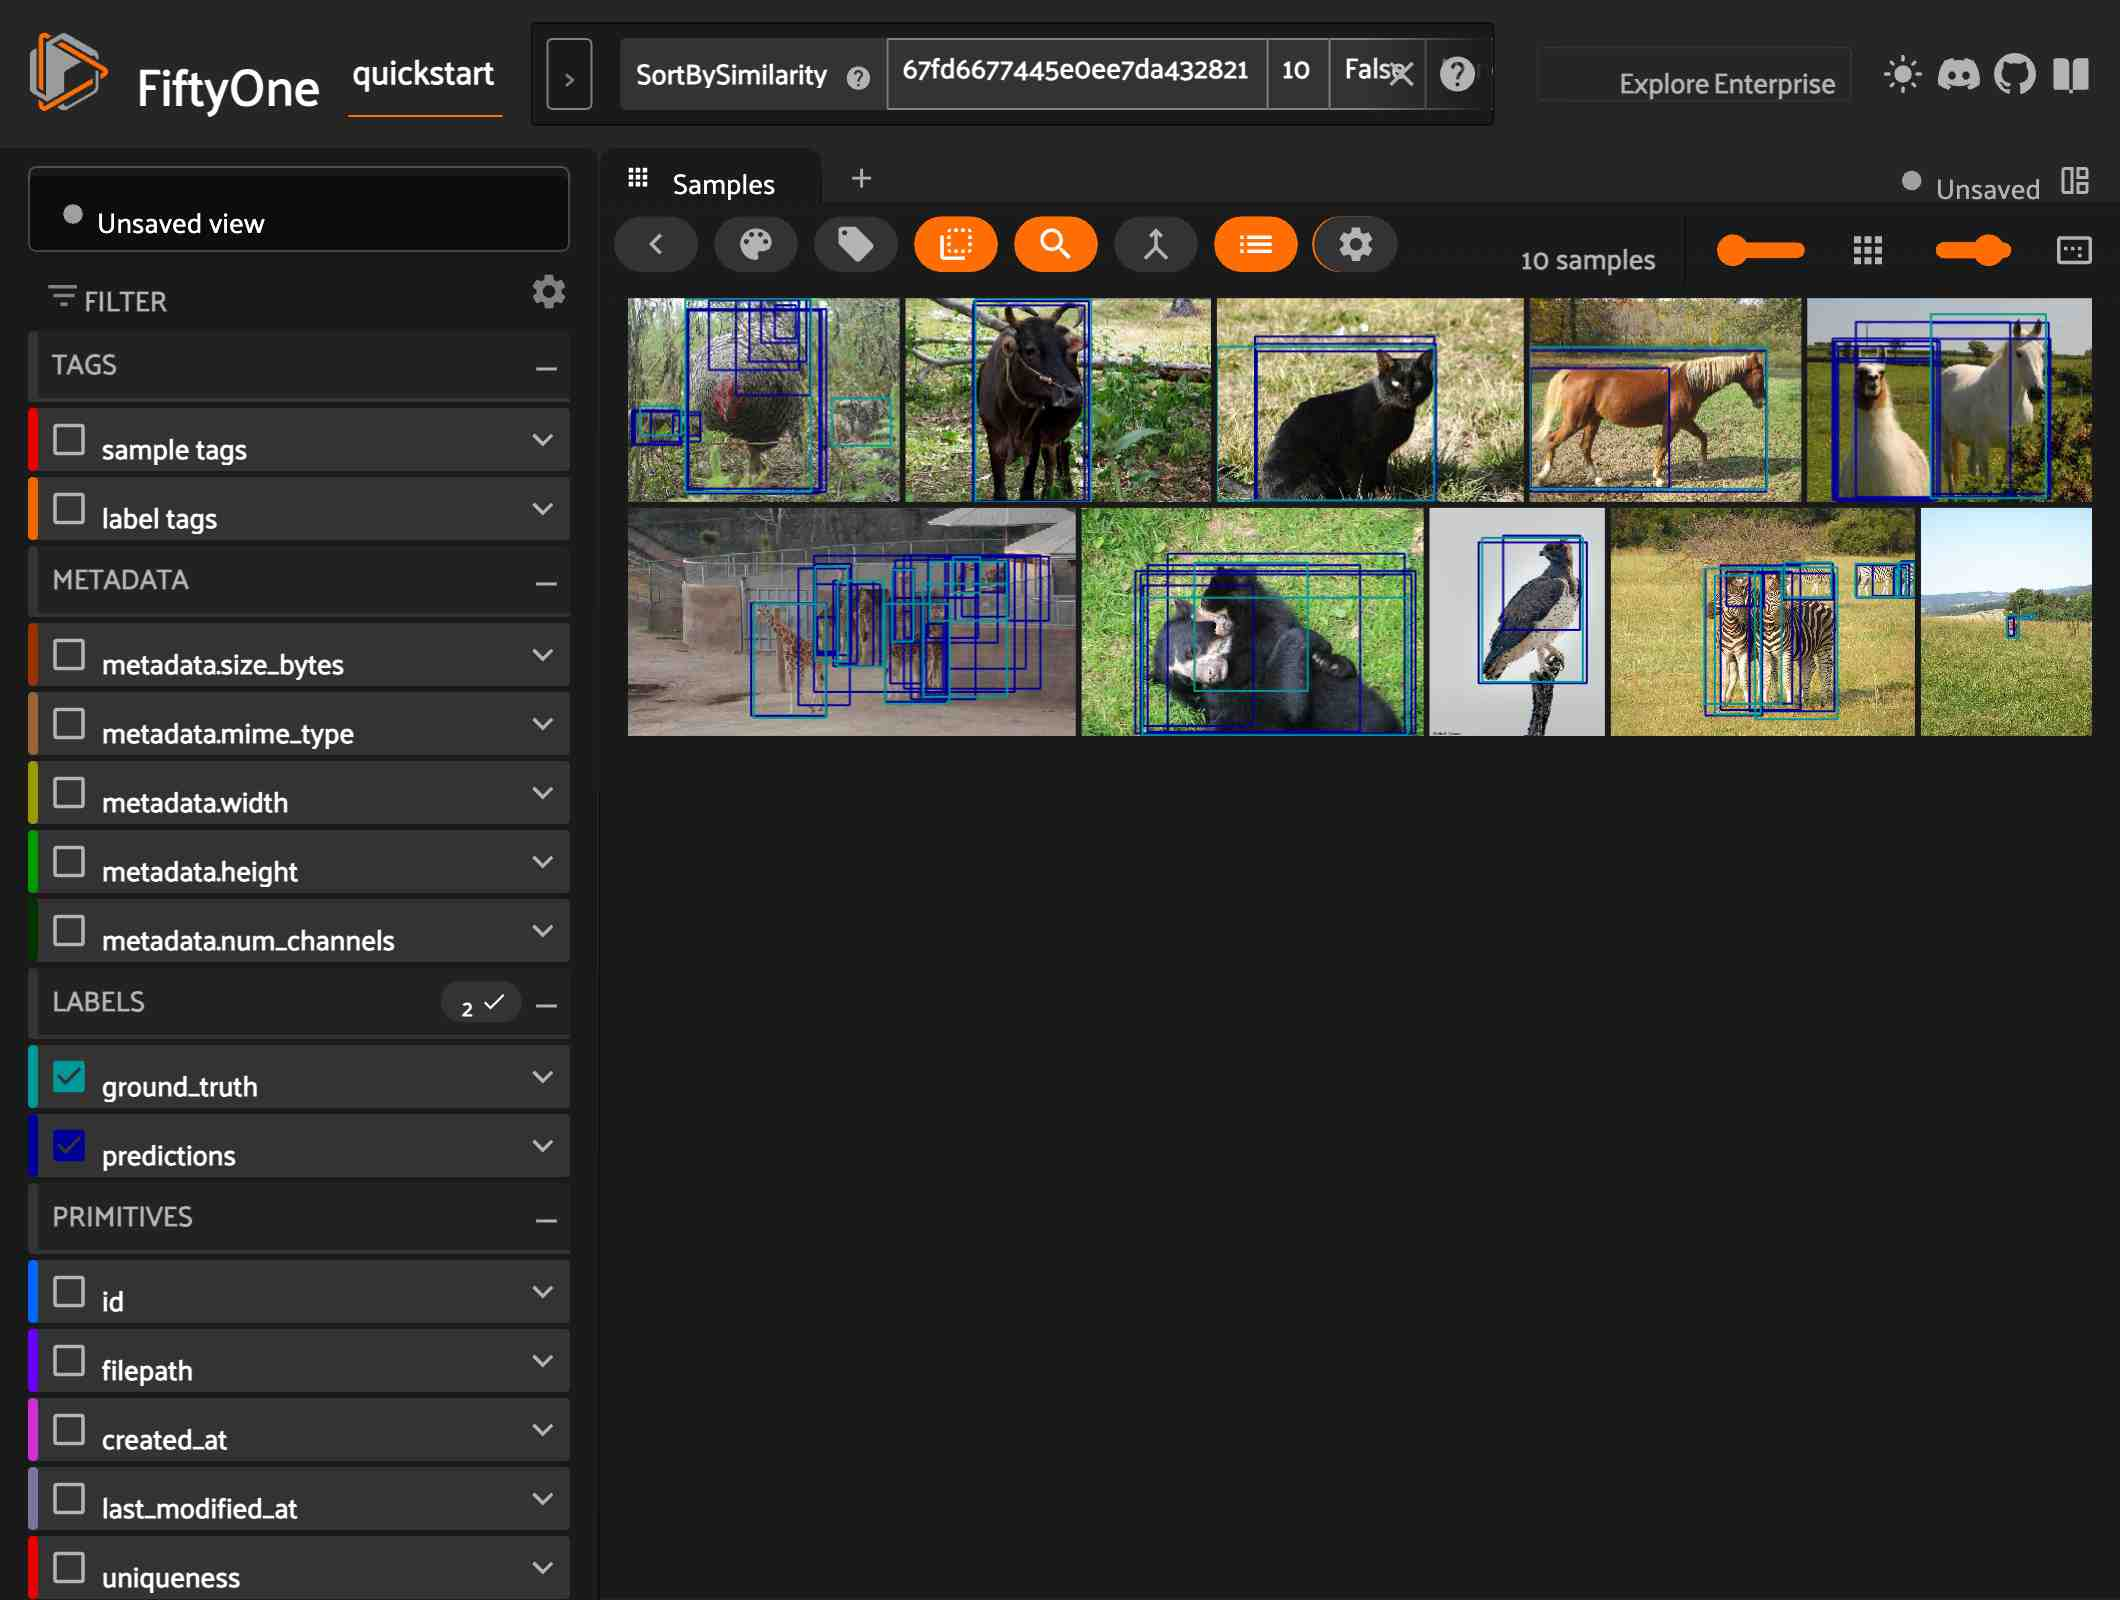

In [ ]:
# Query by first image sample
query = dataset.first().id
view = dataset.sort_by_similarity(query, brain_key="mosaic_index_5", k=10)
session.view = view

![Image](assests/similarity.png)

In [ ]:
# Query by text prompt
query_txt = "a beach"
view_txt = dataset.sort_by_similarity(query_txt, k=50, brain_key="mosaic_index_5")
session.view = view_txt

[NOTICE] Using a Personal Authentication Token (PAT). Recommended for development only. For improved performance, please use Service Principal based authentication. To disable this message, pass disable_notice=True.


![Image](assests/beach.png)

## Cleanup (Optional)

In [ ]:
# Delete Mosaic index and run record
mosaic_index.cleanup()
dataset.delete_brain_run("mosaic_index")
#dataset.delete_brain_runs()